# Flow Model from $\mathcal{N}(0,I_d) \rightarrow $ different data dist.

In [1]:
import torch
from torch import nn
import sklearn.datasets
from tqdm import tqdm
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from abc import ABC, abstractmethod


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Properties
1. Unconditional Flow Model to convert samples of $\mathcal{N}(0, I_d)$ to samples of the given data dist.
# Procedures:


### Training:
1. Train a neural network that will work as the vector field of the ODE
2. for training, we use this loss: 
$$ \mathcal{L}(\theta) = \mathbb{E}_{z \sim p_{data}, t \sim \mathcal{U}[0,1), x \sim p_t(x|z)}[ ||u^{\theta}_{t}(x) - u^{target}_{t}(x | z)||^2 ]$$
-> for gaussian probability path, $x \sim p_t(x|z) = \mathcal{N}({\alpha}_t z, {\beta}_t^2 I_d) $ which just boils down to $x = {\alpha_t} z + {\beta}_t \epsilon, \epsilon \sim \mathcal{N}(0, I_d)$ <br/>
-> the reference field $u^{target}_{t}(x | z) = (d{\alpha}_t - \frac{d{\beta}_t}{{\beta}_t}{\alpha}_t)z + \frac{d{\beta}_t}{{\beta}_t} x$
$$ \mathcal{L}(\theta) = \mathbb{E}_{z \sim p_{data}, t \sim \mathcal{U}[0,1), \epsilon \sim \mathcal{N}(0, I_d) }[ ||u^{\theta}_{t}({\alpha_t} z + {\beta}_t \epsilon) - \biggl( ( d{\alpha}_t - \frac{d{\beta}_t}{{\beta}_t}{\alpha}_t)z + \frac{d{\beta}_t}{{\beta}_t} ({\alpha_t} z + {\beta}_t \epsilon) \biggr) ||^2 ] $$
$$ \mathcal{L}(\theta) = \mathbb{E}_{z \sim p_{data}, t \sim \mathcal{U}[0,1), \epsilon \sim \mathcal{N}(0, I_d) }[ ||u^{\theta}_{t}({\alpha_t} z + {\beta}_t \epsilon) - ( d{\alpha}_tz + d{\beta}_t \epsilon ) ||^2 ] $$
which is approximated using monte carlo approximation:
$$ \frac{1}{N}\sum_{i = 0}^{N}||u^{\theta}_{t}({\alpha_t} z_i + {\beta}_t \epsilon) - ( d{\alpha}_tz_i + d{\beta}_t \epsilon ) ||^2 $$
where N is the batch size

### Sampling:
1. Simulate $ dX_t = u^{\theta}_t(X_t)dt $ through the euler scheme :
$$ X_0 \sim p_{init}, \:\:    X_{t+h} = X_t + hu_t^{\theta}(X_t)$$
2. get 
$$ X_1 \sim p_{data} $$

#### Notes:
1. num timesteps must be same in training and sampling, timesteps ts = linspace(0, 1, 1000) to get h = 1/1000 during sampling
2. sample z from $p_{data}$ by sampling from dataloader
3. sample $X_0$ from $p_{init}$ using torch.randn

In [3]:
class ODE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt : torch.Tensor, t : torch.Tensor) -> torch.Tensor:
        pass

class Sampleable(ABC):
    '''
    A distribution that is sampleable
    '''
    @abstractmethod
    def sample(self, num_samples : int) -> torch.Tensor:
        '''
        returns torch.Tensor of size (num_samples, *dim) of samples from this distribution
        '''
        pass

class Alpha(ABC):
    def __init__(self):
        assert torch.allclose(
            self(torch.zeros(1,1)), torch.zeros(1,1)
        )

        assert torch.allclose(
            self(torch.ones(1,1)), torch.ones(1,1)
        )
    @abstractmethod
    def __call__(self, t : torch.Tensor) -> torch.Tensor:
        pass
    @abstractmethod
    def dt(self, t : torch.Tensor) -> torch.Tensor:
        pass

class Beta(ABC):
    def __init__(self):
        assert torch.allclose(
            self(torch.zeros(1,1)), torch.ones(1,1)
        )

        assert torch.allclose(
            self(torch.ones(1,1)), torch.zeros(1,1)
        )
    @abstractmethod
    def __call__(self, t : torch.Tensor) -> torch.Tensor:
        pass
    @abstractmethod
    def dt(self, t : torch.Tensor) -> torch.Tensor:
        pass

class ConditionalProbabilityPath(nn.Module, ABC):
    def __init__(self, p_init : Sampleable, p_data : Sampleable):
        super().__init__()
        self.p_init = p_init
        self.p_data  = p_data

    @abstractmethod
    def sample_conditioning_variable(self, batch_size : int) -> torch.Tensor:
        '''
        sample the conditioning variable z for p_t(x | z)
        '''
        pass

    @abstractmethod
    def sample_conditional_path(self, z : torch.Tensor, t : torch.Tensor) -> torch.Tensor:
        '''
        sample the path x_t ~ p_t(*|z)
        '''
        pass

    @abstractmethod
    def conditional_vector_field(self, x : torch.Tensor, z : torch.Tensor, t : torch.Tensor) -> torch.Tensor:
        '''
        evaluates the conditional vector field u_t(x|z)
        '''
        pass

In [4]:
class StandardGaussian(Sampleable):
    def __init__(self, dim : int):
        self.dist = torch.distributions.MultivariateNormal(loc = torch.zeros(dim), covariance_matrix=torch.eye(dim))
    
    def sample(self, num_samples):
        return self.dist.sample((num_samples,))

In [5]:
class SwissRollDistribution(Sampleable):
    def __init__(self):
        super().__init__()
        data, _ = sklearn.datasets.make_swiss_roll(n_samples=200000, noise = 0.5)
        data = torch.from_numpy(data[:,[0,2]])
        self.data = data

    def sample(self, num_samples : int) -> torch.Tensor:

        if num_samples > self.data.shape[0]:
            raise ValueError(f'num_samples {num_samples} exceeds dataset size {self.data.shape}')
        
        indices = torch.randperm(len(self.data))[:num_samples]
        samples = self.data[indices]
        return samples

class SqrtAlpha(Alpha):
    def __call__(self,t : torch.Tensor) -> torch.Tensor:
        return torch.sqrt(t)

    def dt(self, t : torch.Tensor) -> torch.Tensor:
        return  1 / (2 * torch.sqrt(t) + 1e-6)

class SquaredBeta():
    def __call__(self, t : torch.Tensor) -> torch.Tensor:
        return 1 - t**2 + 1e-6
    
    def dt(self, t : torch.Tensor) -> torch.Tensor:
        return - 2 * t    
  
class GaussianProbabilityPath(ConditionalProbabilityPath):
    def __init__(self, p_data : Sampleable, alpha : Alpha, beta : Beta):
        p_init = StandardGaussian(2)
        super().__init__(p_init, p_data)
        assert self.p_data.sample(1).shape == self.p_init.sample(1).shape
        self.alpha = alpha
        self.beta = beta

    def sample_conditioning_variable(self, batch_size : int) -> torch.Tensor:
        z = self.p_data.sample(batch_size)
        return z

    def sample_conditional_path(self, z : torch.Tensor, t : torch.Tensor) -> torch.Tensor:
        x = self.alpha(t) * z + self.beta(t) * self.p_init.sample(z.shape[0]).to(device)
        return x

    def conditional_vector_field(self, x: torch.Tensor, z : torch.Tensor, t : torch.Tensor) -> torch.Tensor:
        u_target = (self.alpha.dt(t) - self.beta.dt(t) / (self.beta(t)) * self.alpha(t)) * z + self.beta.dt(t) / (self.beta(t)) * x 
        return u_target  


In [22]:
class LearnedODE(ODE):
    def __init__(self, net : nn.Module, z : torch.Tensor):
        self.z = z
        self.net = net

    def drift_coefficient(self, x : torch.Tensor, t : torch.Tensor) -> torch.Tensor:
        return self.net(x,t)

class TrueFlowODE(ODE):
    def __init__(self, path : ConditionalProbabilityPath, z : torch.Tensor):
        self.path = path
        self.z = z

    def drift_coefficient(self, x : torch.Tensor, t : torch.Tensor) -> torch.Tensor:
        bs = x.shape[0]
        z = self.z.expand(bs, *self.z.shape[1:]).to(device)
        return self.path.conditional_vector_field(x, z, t)
        
class EulerSimulator():
    def __init__(self, ode : ODE):
        self.ode = ode

    def step(self, xt : torch.Tensor, t : torch.Tensor, h : torch.Tensor) -> torch.Tensor:
        return xt + h * self.ode.drift_coefficient(xt, t)

Text(0.5, 1.0, 'target dist.')

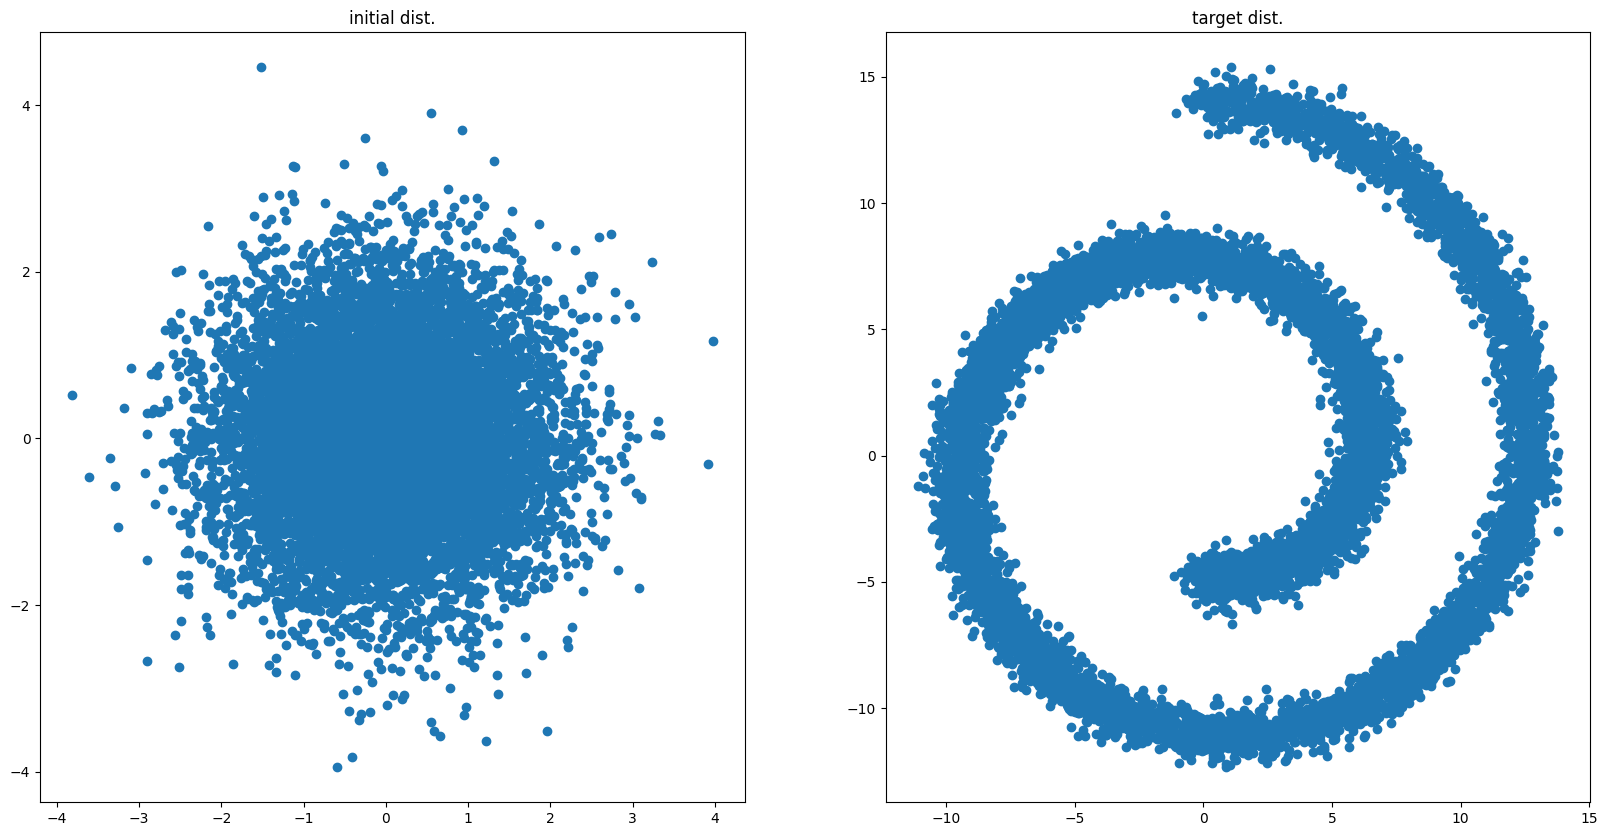

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_dist = SwissRollDistribution()
alpha = SqrtAlpha()
beta = SquaredBeta()
path = GaussianProbabilityPath(data_dist, alpha, beta)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
init_samples = path.p_init.sample(10000)
plt.scatter(init_samples[:,0], init_samples[:,1])
plt.title('initial dist.')
plt.subplot(1, 2, 2)
target_samples = path.p_data.sample(10000)
plt.scatter(target_samples[:,0], target_samples[:,1])
plt.title('target dist.')

In [ ]:
def simulate_true_flow(
        path,    
        simulator,
        num_timesteps=200,
        device=device,
        num_plots=6
):
    bs = simulator.ode.z.shape[0]
    
    # sample initial distribution
    x = path.p_init.sample(bs).to(device)

    # timesteps and step size
    ts = torch.linspace(0.001, 1.0, num_timesteps).view(-1, 1, 1).expand(-1, bs, 1).to(device)
    h = 1 / num_timesteps

    snapshots = []

    #simulate
    for i in range(num_timesteps):
        x = simulator.step(x, ts[i], h)
        # Save snapshot every fixed interval
        if i % (num_timesteps // num_plots) == 0:
            snapshots.append(x.detach().cpu())

    # Plot
    fig, axes = plt.subplots(1, len(snapshots), figsize=(4 * len(snapshots), 4))
    for i, x_snap in enumerate(snapshots):
        ax = axes[i] if isinstance(axes, (list, np.ndarray)) else axes
        ax.scatter(x_snap[:, 0], x_snap[:, 1], s=5, color='green')
        ax.set_title(f't = {ts[i * (num_timesteps // num_plots)][0].item():.2f}')
        ax.set_xlim(-20, 20)
        ax.set_ylim(-20, 20)
        ax.set_aspect('equal')

    plt.tight_layout()
    plt.show()

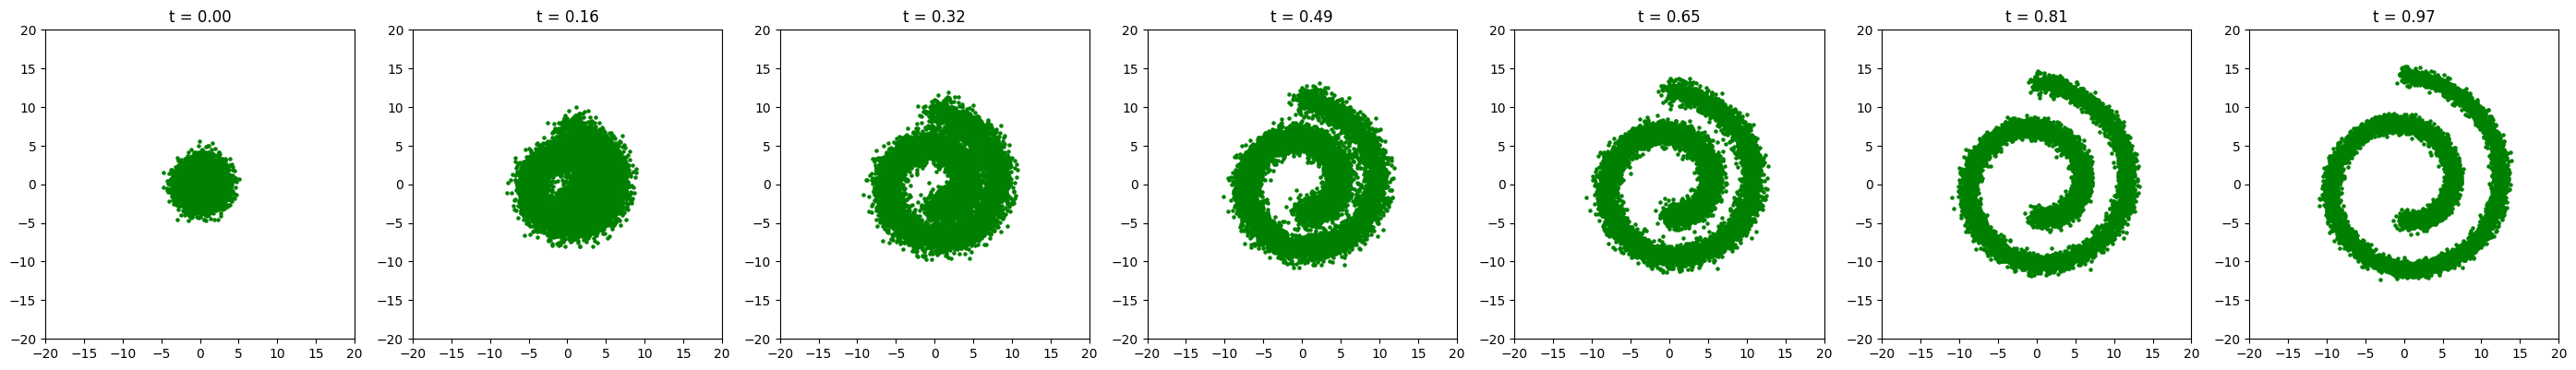

In [9]:
z = path.sample_conditioning_variable(10000)

ode = TrueFlowODE(path=path, z=z)
sim = EulerSimulator(ode)

simulate_true_flow(path=path, simulator=sim, num_timesteps=100, device=device)

In [10]:
class SCurveDistribution(Sampleable):
    def __init__(self):
        super().__init__()
        data, _ = sklearn.datasets.make_s_curve(n_samples=20000,noise = 0.1)
        data = torch.from_numpy(data[:,[0,2]]) * 10.0
        self.data = data

    def sample(self, num_samples) -> torch.Tensor:
        indices = torch.randperm(len(self.data))[:num_samples]
        samples = self.data[indices]
        return samples

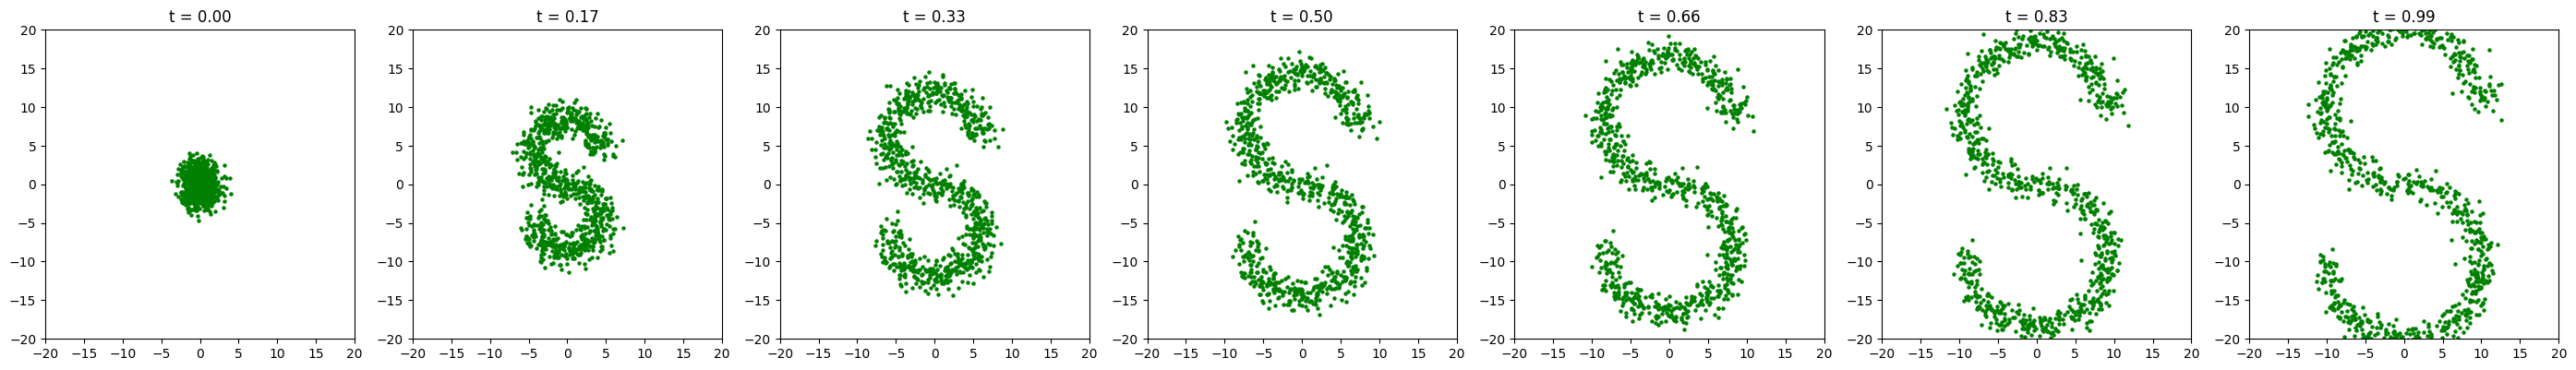

In [11]:
path = GaussianProbabilityPath(
    p_data = SCurveDistribution(),
    alpha=alpha,
    beta=beta
)

z = path.sample_conditioning_variable(900)

ode = TrueFlowODE(path=path, z=z)
sim = EulerSimulator(ode)

simulate_true_flow(path, sim, 200)

In [12]:
def build_mlp(dims, activation = torch.nn.SiLU):
        mlp = []
        for idx in range(len(dims) - 1):
            mlp.append(torch.nn.Linear(dims[idx], dims[idx + 1]))
            if idx < len(dims) - 2:
                mlp.append(activation())
        return torch.nn.Sequential(*mlp)

class MLPVectorField(torch.nn.Module):
    """
    MLP-parameterization of the learned vector field u_t^theta(x)
    """
    def __init__(self, dim : int, hiddens):
        super().__init__()
        self.dim = dim
        self.net = build_mlp([dim + 1] + hiddens + [dim])

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        Args:
        - x: (bs, dim)
        Returns:
        - u_t^theta(x): (bs, dim)
        """
        

        xt = torch.cat([x,t], dim=-1)
        return self.net(xt) 

In [13]:
class FlowMatchingTrainer():
    def __init__(self, path : ConditionalProbabilityPath, model : nn.Module):
        self.path = path
        self.model = model
        pass

    def get_optimizer(self, lr : float):
        return torch.optim.Adam(self.model.parameters(), lr=lr)
    
    def get_train_loss(self, batch_size : int) -> torch.Tensor:
        z = self.path.sample_conditioning_variable(batch_size).float().to(device)
        t = torch.rand(batch_size, 1).float().to(device)
        x = self.path.sample_conditional_path(z, t).float().to(device)
        u_t_target = self.path.conditional_vector_field(x, z, t)
        u_t_pred = self.model(x,t)
        loss = torch.mean(torch.norm_except_dim(u_t_pred - u_t_target, dim = 0)**2)
        return loss

    def train(self, num_epochs : int, device : torch.device, lr : float = 1e-3, batch_size : int = 1000) -> torch.Tensor:
        self.model
        self.path

        opt = self.get_optimizer(lr)
        self.model.train()

        losses = []
        pbar = tqdm(enumerate(range(num_epochs)))
        for idx, epoch in pbar:
            opt.zero_grad()
            loss = self.get_train_loss(batch_size)
            loss.backward()
            opt.step()
            losses.append(loss.detach())
            pbar.set_description(f'Epoch {idx}, loss: {loss.item()}')


        self.model.eval()
        return torch.stack(losses)

In [24]:
class LinearAlpha(Alpha):
    def __call__(self, t):
        return t
    def dt(self, t):
        return torch.ones_like(t)
class SqrtBeta(Beta):
    def __call__(self, t):
        return torch.sqrt(1 - t)
    def dt(self, t):
        return -1/(2  * torch.sqrt(1 - t))
    

In [26]:
net = MLPVectorField(2,[100,100,100,100,100]).to(device)      
path = GaussianProbabilityPath(
    p_data=SwissRollDistribution(),
    alpha=LinearAlpha(),
    beta=SqrtBeta()
).to(device)
trainer = FlowMatchingTrainer(path, net)
losses = trainer.train(2000, device, 1e-3, batch_size=10000)


Epoch 1999, loss: 43.96503448486328: : 2000it [00:19, 103.68it/s] 


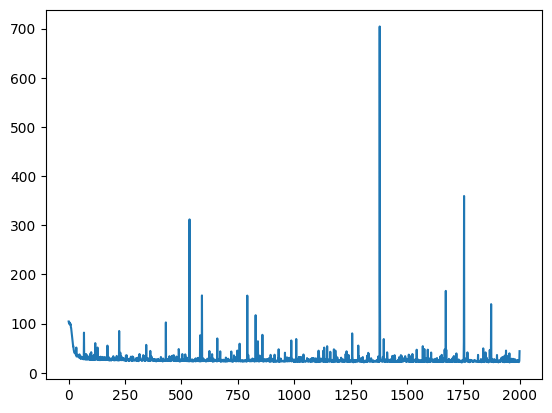

In [27]:

plt.plot(losses.cpu())


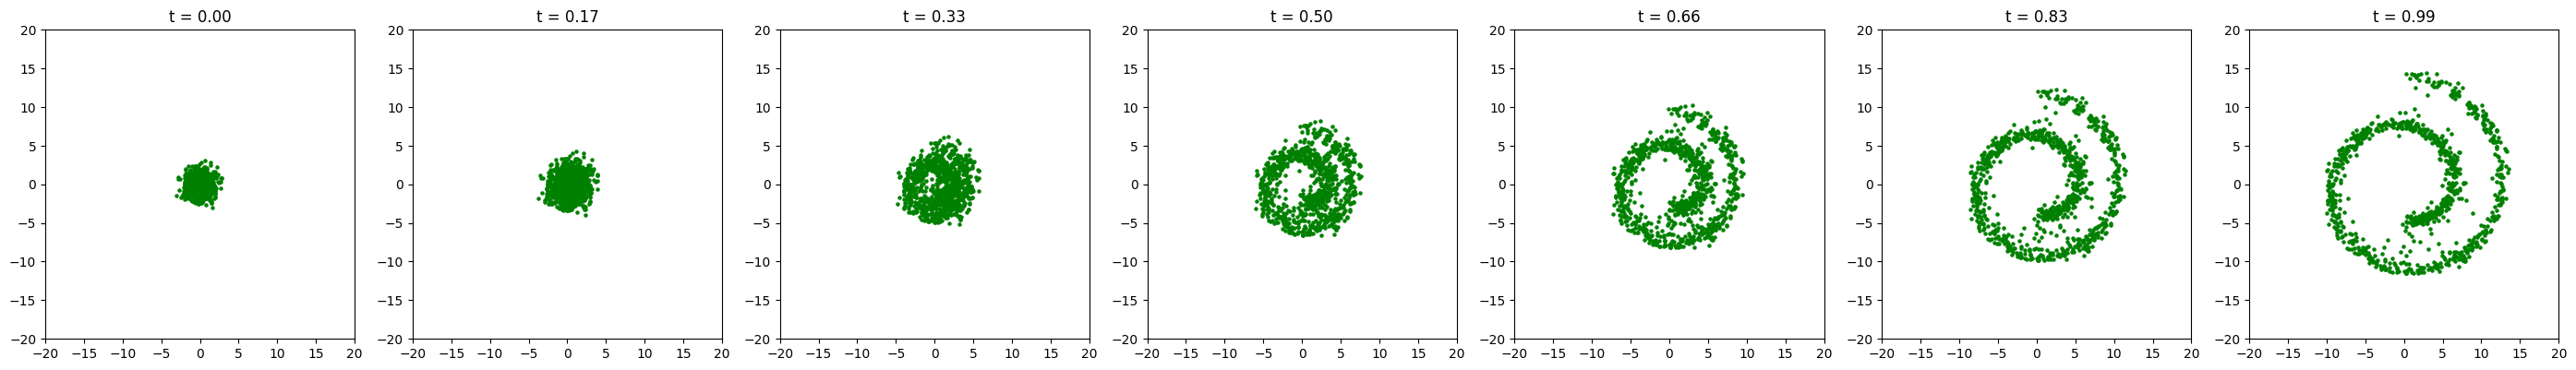

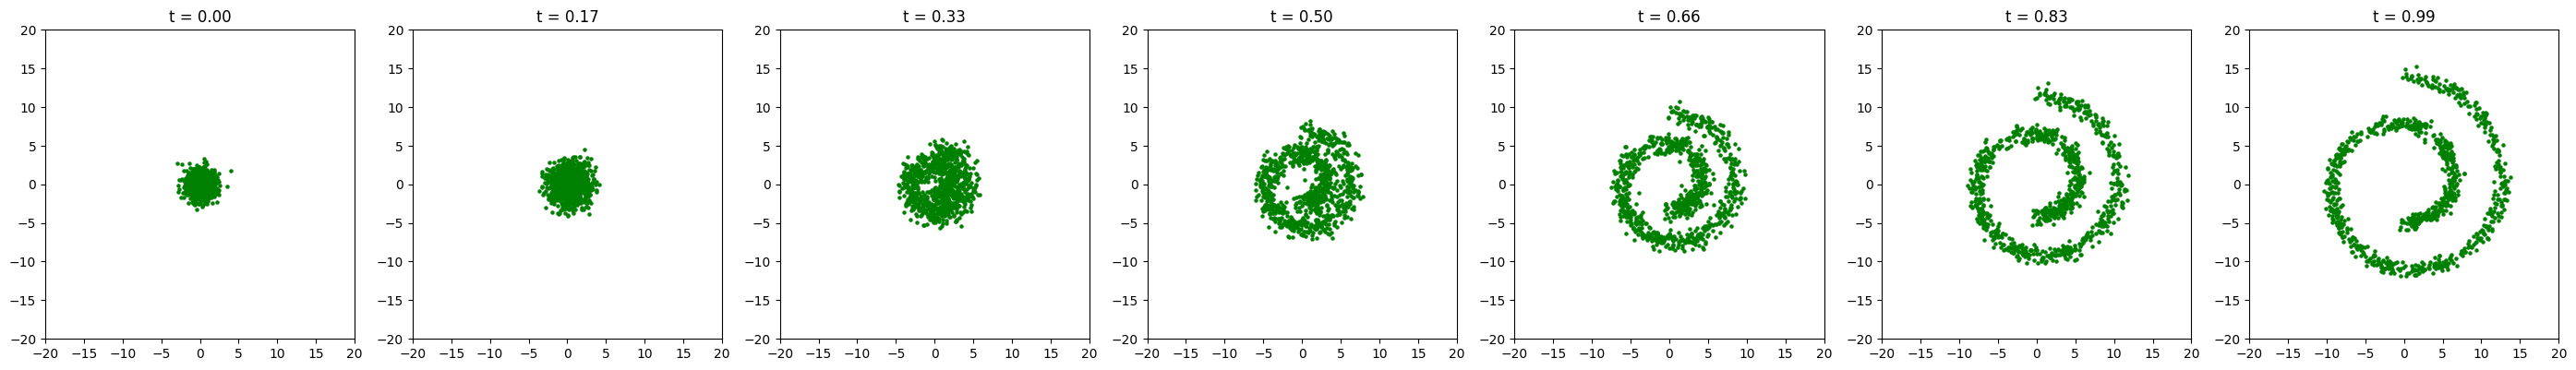

In [28]:
z = path.sample_conditioning_variable(900)
ode = LearnedODE(net, z)
sim = EulerSimulator(ode)

simulate_true_flow(path=path, simulator=sim)


ode = TrueFlowODE(path, z)
sim = EulerSimulator(ode)
simulate_true_flow(path=path, simulator=sim)

In [34]:
class LinearProbabilityPath(ConditionalProbabilityPath):
    def __init__(self, p_init, p_data):
        super().__init__(p_init, p_data)
    
    def sample_conditioning_variable(self, batch_size):
        z = self.p_data.sample(batch_size)
        return z
    def sample_conditional_path(self, z, t):
        x0 = self.p_init.sample(z.shape[0]).to(device)
        x = (1 - t) * x0 + t * z
        return x
    def conditional_vector_field(self, x, z, t):
        u_t =  (z - x) / (1 - t + 1e-6)
        return u_t

Epoch 4999, loss: 15.713951110839844: : 5000it [00:36, 138.67it/s]


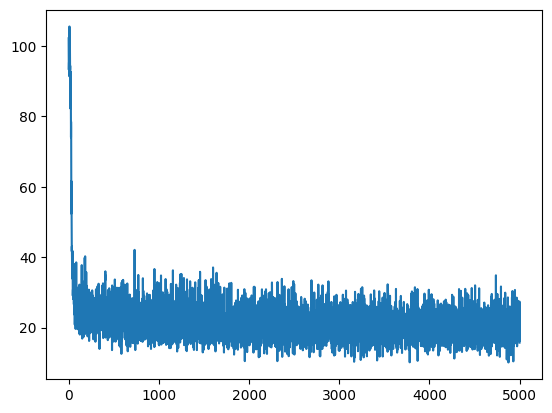

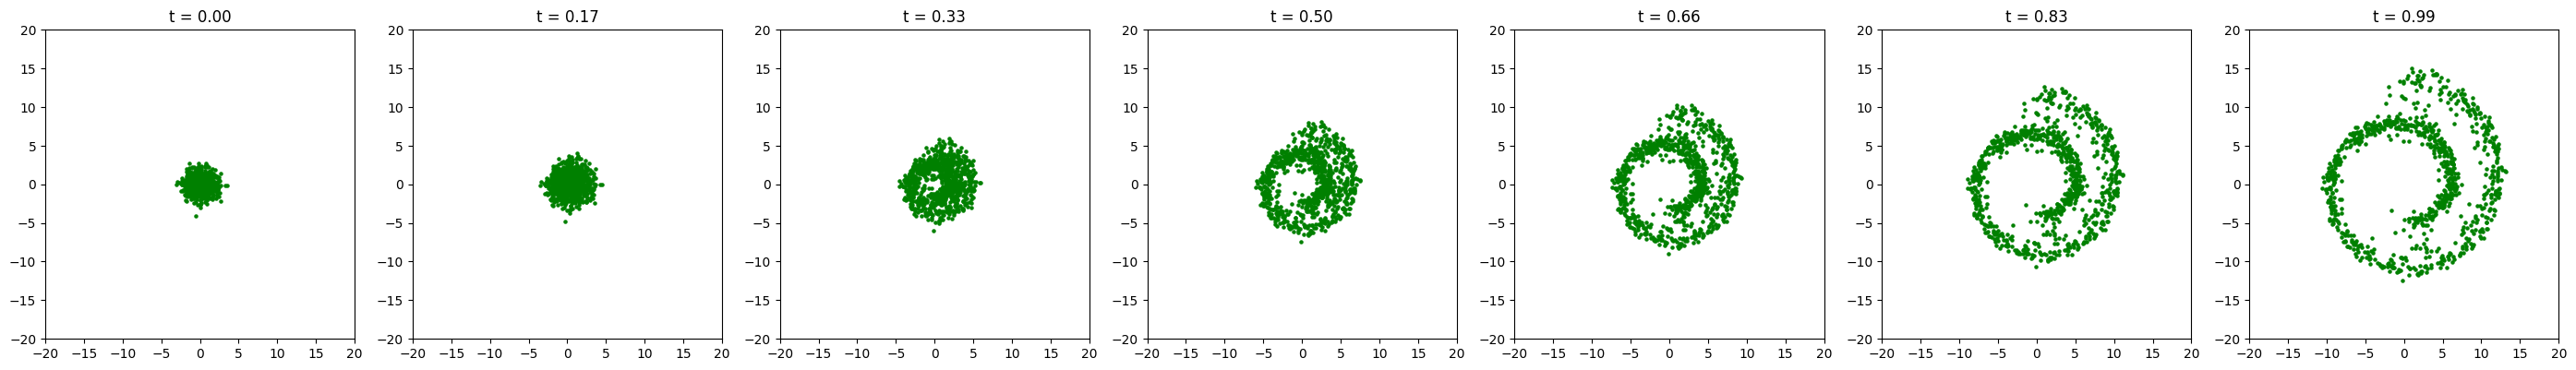

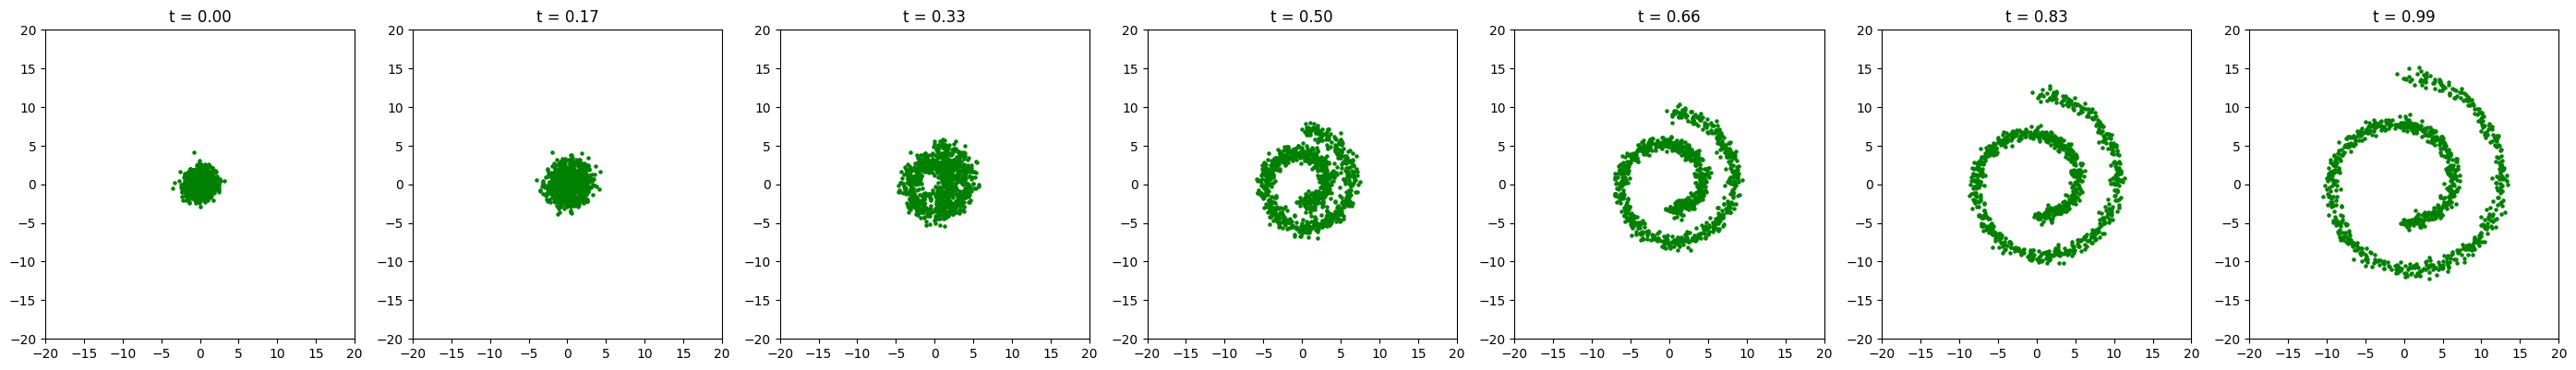

In [35]:
net = MLPVectorField(2,[64, 64, 64, 64, 64, 64]).to(device)
path = LinearProbabilityPath(
    p_init=StandardGaussian(2),
    p_data=SwissRollDistribution(),
).to(device)
trainer = FlowMatchingTrainer(path, net)
losses = trainer.train(5000, device, 1e-3, batch_size=100)

plt.plot(losses.cpu())


z = path.sample_conditioning_variable(900)
ode = LearnedODE(net, z)
sim = EulerSimulator(ode)

simulate_true_flow(path=path, simulator=sim)


ode = TrueFlowODE(path, z)
sim = EulerSimulator(ode)
simulate_true_flow(path=path, simulator=sim)

Epoch 4999, loss: 32.799461364746094: : 5000it [00:24, 203.01it/s]


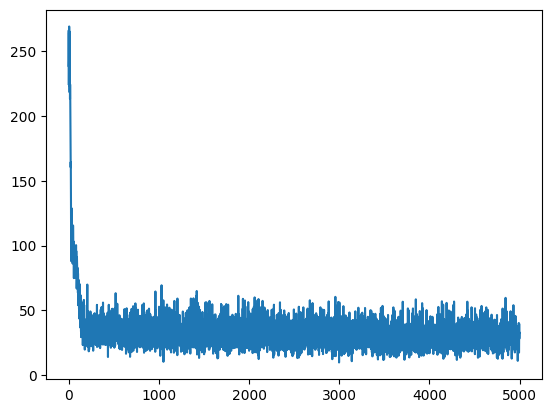

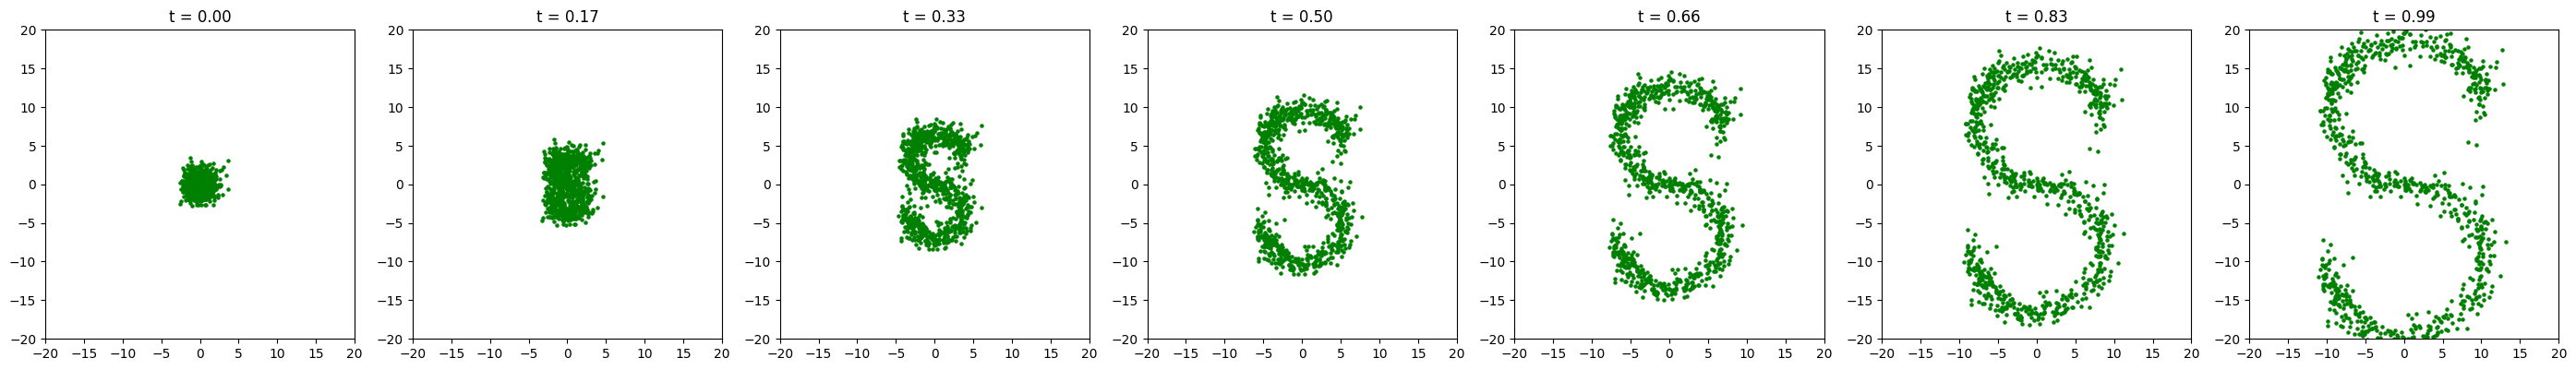

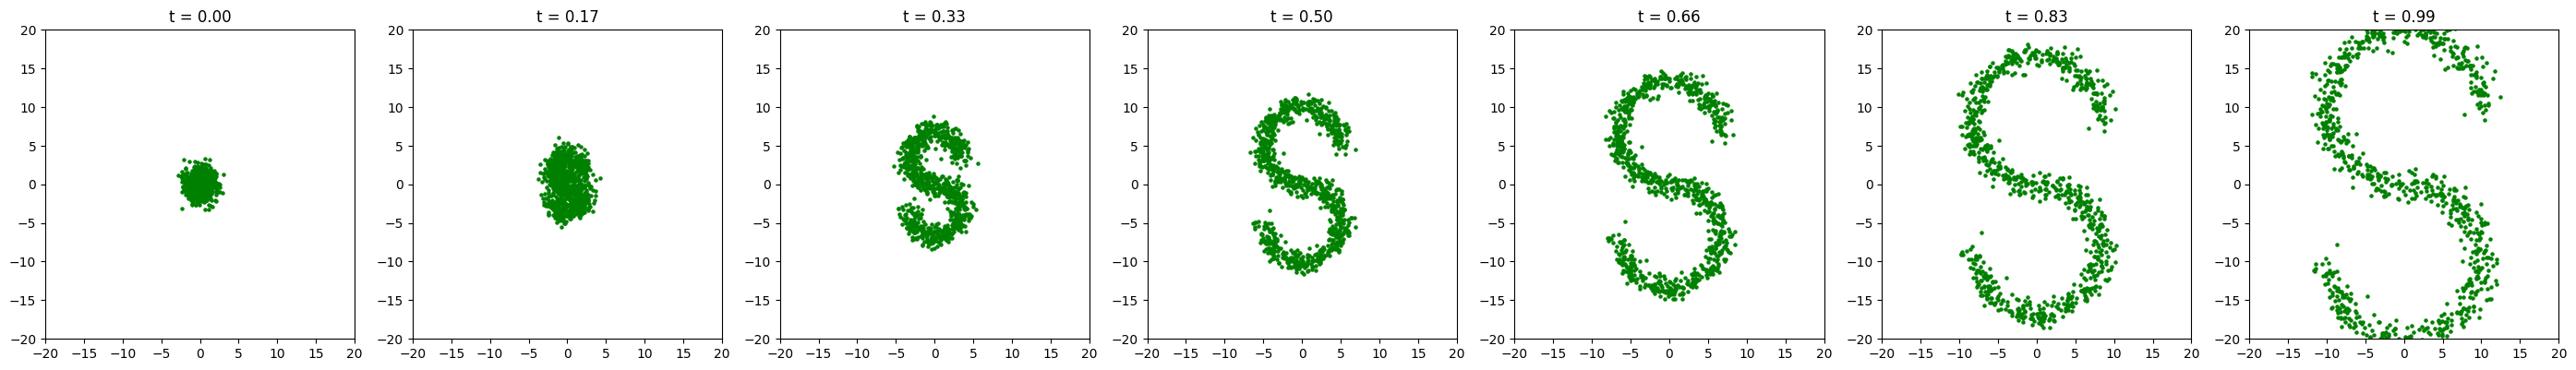

In [36]:
net = MLPVectorField(2,[64, 64, 64, 64, 64, 64]).to(device)
path = LinearProbabilityPath(
    p_init=StandardGaussian(2),
    p_data=SCurveDistribution(),
).to(device)
trainer = FlowMatchingTrainer(path, net)
losses = trainer.train(5000, device, 1e-3, batch_size=100)

plt.plot(losses.cpu())


z = path.sample_conditioning_variable(900)
ode = LearnedODE(net, z)
sim = EulerSimulator(ode)

simulate_true_flow(path=path, simulator=sim)


ode = TrueFlowODE(path, z)
sim = EulerSimulator(ode)
simulate_true_flow(path=path, simulator=sim)